Assorted plots
==============

This contains lots of plots from runs over the last few days (around 15 to 21 July).

It's kind of like the sequel to `ota-basic.py`.

In [1]:
import csv
import json
import random
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# copied from ota-basic.ipynb

abbreviations = {'parameter_radius': 'B', 'noise': 'σₙ²', 'clients': 'n', 'power': 'P', 'data_per_client': 'dpc', 'quantization_range': 'qr', 'zero_bits_strategy': 'zbs'}

def get_args(directory):
    """`directory` must be a pathlib.Path object."""
    argsfile = directory / 'arguments.json'
    with open(argsfile) as f:
        content = json.load(f)
    return content['args']

def get_eval(directory):
    """`directory` must be a pathlib.Path object."""
    argsfile = directory / 'evaluation.json'
    with open(argsfile) as f:
        content = json.load(f)
    return content

def fits_spec(args, specs):
    """Returns True if the given `args` dict matches the given `specs` dict,
    for those entries in `specs`."""
    for key, value in specs.items():
        arg = args[key]
        if value == "__all__":
            matches = True
        elif isinstance(value, list):
            matches = arg in value
        else:
            matches = (arg == value)
        if not matches:
            return False
    return True

In [3]:
# function that plots training charts, like plot_training_charts, but averaged over many iterations

def plot_averaged_training_charts(results_dir: Path, fields: list, title_specs: dict,
                                  fixed_specs: dict, series_specs: dict):
    """Plots training charts (i.e., metrics vs round number) from the results
    in `results_dir`, for each of the metrics specified in `fields`.
    
    `title_specs` and `fixed_specs` are dicts indicating arguments that should always
    match (an assertion fails if any do not match). `series_spec` is a similar dict, 
    but the values should be lists or the special string `"__all__"`, and this dict is 
    used to differentiate between series.
    
    All arguments must be in one of the three `specs` dicts. This is to protect against
    accidentally averaging mismatched data. An assertion fails if an argument is found
    in the results directories that is not in any of these dicts. If you want to skip
    certain values of an argument (e.g., only plot those with a noise level of 0.1),
    such values should be placed in `series_specs` as a list of one item.
    """

    # General strategy: Step through each directory, and for each one:
    #  - check that fixed specs match
    #  - determine which series it belongs to based on series specs
    #  - add it to a DataFrame for that series
    # then at the end, take the averages for each DataFrame, and put it in an overall DataFrame.
    # We actually do this for each metric in `fields`, so we track dicts of {field-name: DataFrame}.

    fig, axs = plt.subplots(1, len(fields), figsize=(8*len(fields), 5))
    if len(fields) == 1:
        axs = [axs]  # annoying matplotlib quirk
    directories = [e for d in results_dir.iterdir() if d.is_dir() for e in d.iterdir() if e.is_dir()]
    data = {}
    all_args = set(title_specs) | set(fixed_specs) | set(series_specs) | {'cpu', 'repeat'}

    for directory in directories:
        
        # Check that args match plot specs
        args = get_args(directory)
        assert set(args.keys()) == all_args, "missing keys: " + str(all_args - set(args.keys()))
        assert fits_spec(args, fixed_specs)
        assert fits_spec(args, title_specs)
        if not fits_spec(args, series_specs):
            continue

        # Get the DataFrames for this series (create if necessary)
        series = tuple(args[key] for key in series_specs.keys())  # identifier for series
        if series not in data:  # don't use setdefault to avoid generating this every time
            data[series] = {field: pd.DataFrame() for field in fields}
        dfs = data[series]

        # Add the data to these DataFrames
        training = pd.read_csv(directory / "training.csv")
        for field in fields:
            dfs[field][directory] = training[field]

    reduced = {field: pd.DataFrame() for field in fields}
    sample_sizes = {}

    # Take averages and put them in new DataFrames
    for series in sorted(data.keys()):  # sort tuples to get sensible series order
        dfs = data[series]
        series_name = ", ".join(f"{abbreviations.get(key, key)}={value}" for key, value in zip(series_specs, series))
        sample_size = dfs[field].shape[1]
        series_name += f" ({sample_size})"
        for field in fields:
            reduced[field][series_name] = dfs[field].mean(axis=1)

    title_suffix = ", ".join(f"{abbreviations.get(key, key)}={value}" for key, value in title_specs.items())
    
    # Plot them
    for ax, field in zip(axs, fields):
        reduced[field].plot(ax=ax)
        ax.legend()
        ax.set_xlabel("round")
        ax.set_ylabel(field)
        ax.set_title(field + "\n" + title_suffix)
    

# function that plots final accuracy vs number of clients, but averaged over many iterations

def plot_evaluation_vs_clients(results_dir: Path, fields: list, title_specs: dict,
                               fixed_specs: dict, series_specs: dict):
    
    # Similar strategy to plot_averaged_training_charts; there's actually some amount of nonideal
    # code duplication. The main difference is that here we're collecting and averaging for each
    # point, not on a per-series basis.

    clients_range = range(2, 31)
    fig, axs = plt.subplots(1, len(fields), figsize=(8*len(fields), 5))
    if len(fields) == 1:
        axs = [axs]  # annoying matplotlib quirk
    directories = [e for d in results_dir.iterdir() if d.is_dir() for e in d.iterdir() if e.is_dir()]
    data = {}
    all_args = set(title_specs) | set(fixed_specs) | set(series_specs) | {'clients', 'cpu', 'repeat'}

    for directory in directories:

        # Check that args match plot specs
        args = get_args(directory)
        assert set(args.keys()) == all_args, "missing keys: " + str(set(args.keys()) - all_args)
        assert fits_spec(args, fixed_specs)
        assert fits_spec(args, title_specs)
        if not fits_spec(args, series_specs):
            continue
        clients = args['clients']

        # Get the DataFrames for this series (create if necessary)
        series = tuple(args[key] for key in series_specs.keys())  # identifier for series
        if series not in data:  # don't use setdefault to avoid generating this every time
            data[series] = {(field, c): [] for field in fields for c in clients_range}
        dfs = data[series]

        # Add the data to these DataFrames
        evaluation = get_eval(directory)
        for field in fields:
            data[series][(field, clients)].append(evaluation[field])

    reduced = {field: pd.DataFrame() for field in fields}

    # Take averages and put them in new DataFrames
    for series in sorted(data.keys()):  # sort tuples to get sensible series order
        series_name = ", ".join(f"{abbreviations.get(key, key)}={value}" for key, value in zip(series_specs, series))
        for field in fields:
            for c in clients_range:
                samples = np.array(data[series][(field, c)])
                reduced[field].loc[c, series_name] = samples.mean()

    title_suffix = ", ".join(f"{abbreviations.get(key, key)}={value}" for key, value in title_specs.items())

    # Plot them
    for ax, field in zip(axs, fields):
        reduced[field].plot(ax=ax)
        ax.legend()
        ax.set_xlabel("number of clients")
        ax.set_ylabel(field)
        ax.set_title(field + "\n" + title_suffix)


# Averaged out over many iterations

I ran the $B = 1, \sigma_\mathrm{n}^2 = 0.1$ with 13,333 data samples per client case repeatedly to try to smooth out the graphs above, to get a better idea of expected performance.

These were all done on commit `bef163a`. This after I implemented the class-based framework, so it is probably subject to the bug I noticed in [1b5e659](https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01). However, it won't be extremely noticeable, because all fo the following experiments were done using the same parameters, changing only `clients` (which isn't subject to the bug). Also, the `data_per_client` option isn't subject to the bug, because it's not passed to `Experiment` class constructors in `params`. So basically the only change from defaults was `noise = 0.1`, and there's a good chance the following is actually with `noise = 1.0`, not 0.1 as claimed.

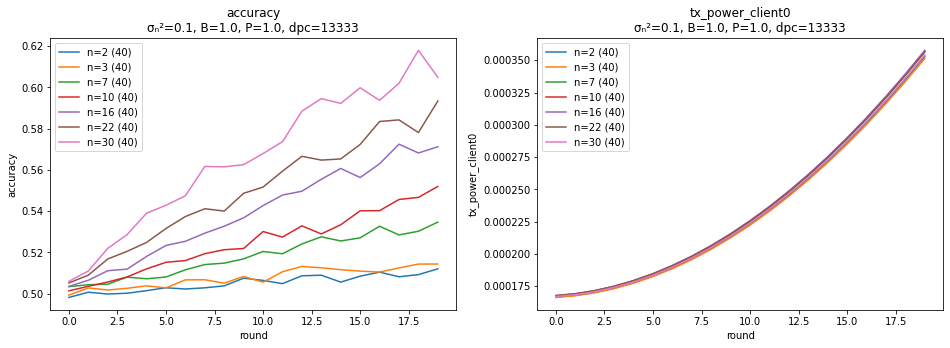

In [4]:
results_dir = Path("../results-downloaded/ota-basic-4/")

title_specs = {
    'noise': 0.1,
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
fixed_specs = {
    'rounds': 20,
    'batch_size': 64,
    'lr_client': 0.01,
    'epochs': 1,
    'small': False,
}
series_specs = {
    'clients': [2, 3, 7, 10, 16, 22, 30],
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


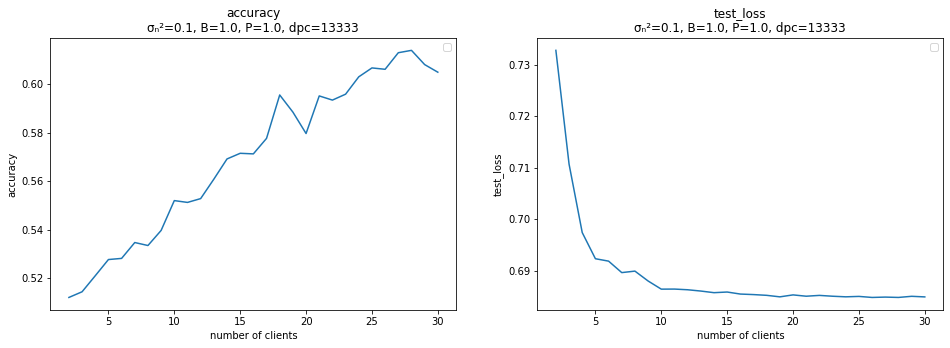

In [5]:
series_specs = {}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Really long experiments on the class-based framework—probably mislabelled

I think these are subject to the bug fixed in commit [`1b5e569`](https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01). See the relevant section below for details. Basically, parameters passed via `params` were probably being ignored. A lot of command-line options weren't necessarily subject to this bug, but some crucial ones were, like `noise`, `power` and `parameter_radius`.

/tmp/ipykernel_3349/1436162414.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs[field][directory] = training[field]


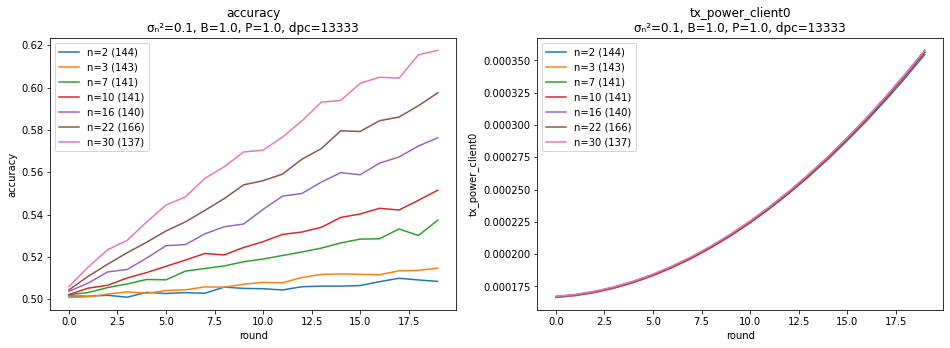

In [6]:
results_dir = Path("../results-downloaded/20210715-20210717-bef163a/")

title_specs = {
    'noise': 0.1,
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
series_specs = {
    'clients': [2, 3, 7, 10, 16, 22, 30],
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


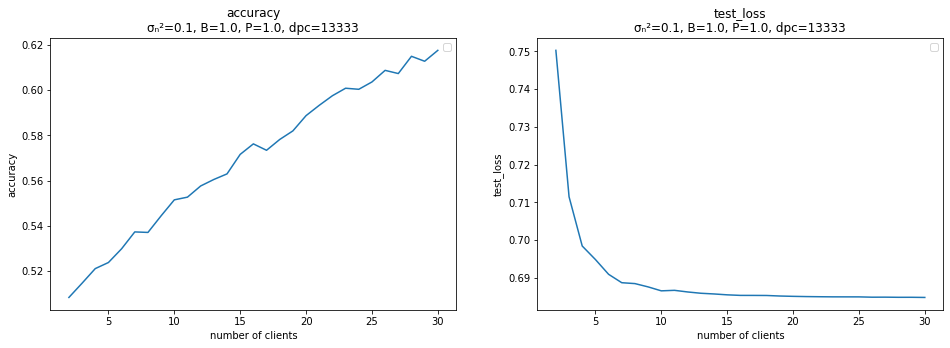

In [7]:
series_specs = {}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Deltas vs params, on commit `9bdb857`—not reliable, discard

These runs didn't run to completion, as in, I stopped them early. This is because I discovered a major bug in parameter handling. See the next section for details, but basically, most command-line arguments were being ignored by the framework.

So I would expect these plots to be identical regardless of what parameters are used, because it's not actually recognizing the parameters!

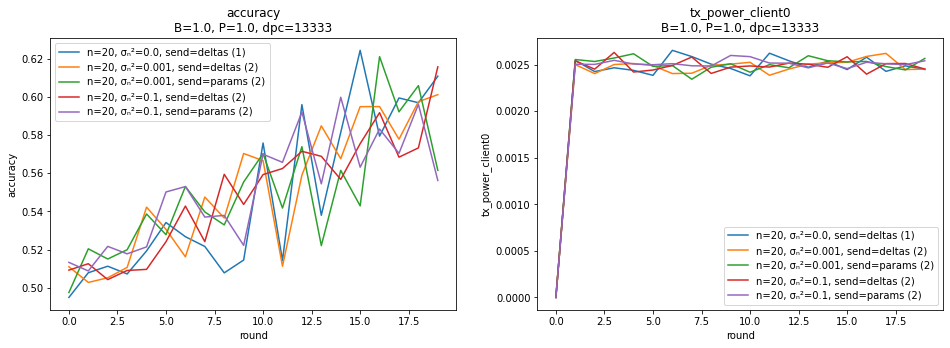

In [8]:
results_dir = Path("../results-downloaded/20210719-9bdb857/")

title_specs = {
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
series_specs = {
    'clients': [20],
    'noise': [0.0, 0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

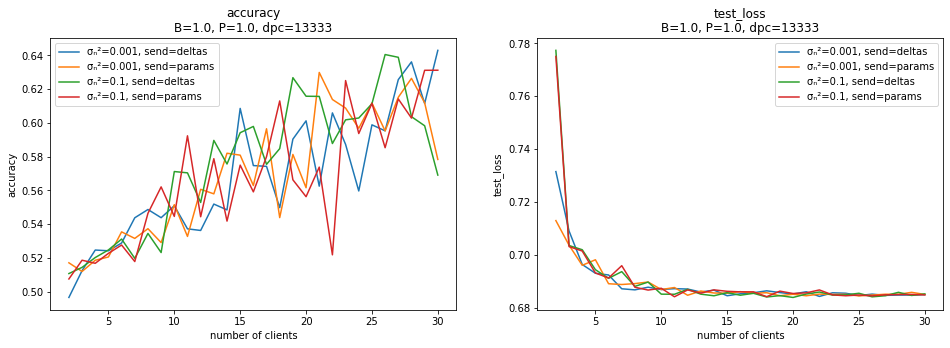

In [9]:
series_specs = {
    'noise': [0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Deltas vs params, on commit `1b5e659`

Okay, here's the fix. You can see this fix here:
> https://github.com/czlee/jadeite/commit/1b5e659b8342f1eeb38c909418512c0568095c01

Or the comparison between this commit and the ones in the following section:
> https://github.com/czlee/jadeite/compare/9bdb857...1b5e659

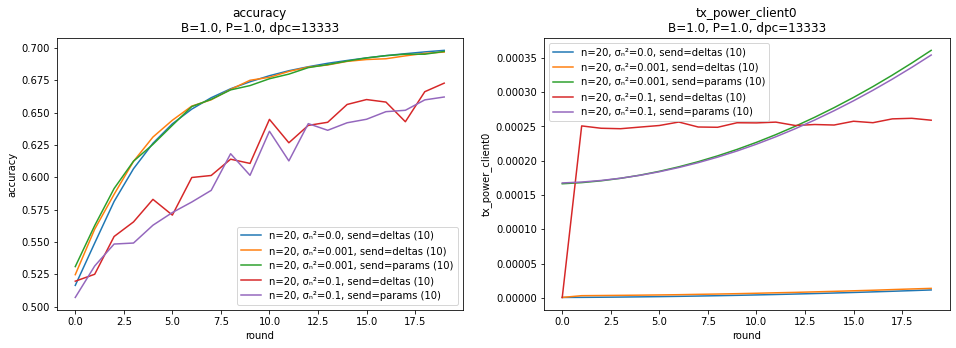

In [10]:
results_dir = Path("../results-downloaded/20210720-1b5e659/")

title_specs = {
    'parameter_radius': 1.0,
    'power': 1.0,
    'data_per_client': 13333,
}
series_specs = {
    'clients': [20],
    'noise': [0.0, 0.001, 0.1],
    'send': '__all__',
}
fields = ['accuracy', 'tx_power_client0']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

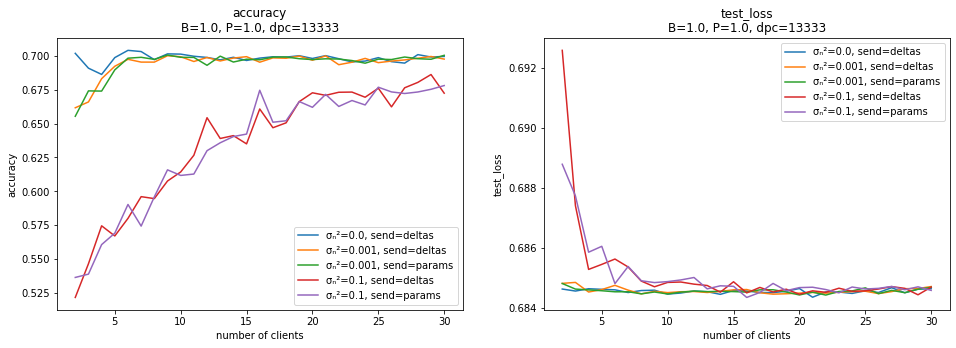

In [11]:
series_specs = {
    'noise': '__all__',
    'send': '__all__',
}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)

# Digital simulations


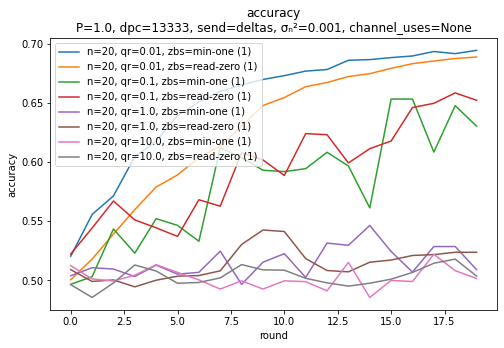

In [12]:
results_dir = Path("../results-downloaded/20210720-stocquant/")

title_specs = {
    'power': 1.0,
    'data_per_client': 13333,
    'send': 'deltas',
    'noise': 0.001,
    'channel_uses': None,
}
series_specs = {
    'clients': [20],
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs)

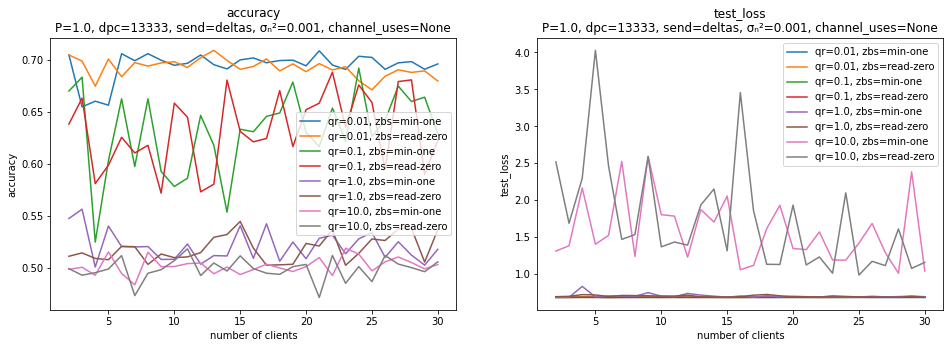

In [13]:
series_specs = {
    'quantization_range': '__all__',
    'zero_bits_strategy': '__all__',
}
fields = ['accuracy', 'test_loss']

plot_evaluation_vs_clients(results_dir, fields, title_specs, fixed_specs, series_specs)